In [9]:
import sys
import os
import re
import glob
import random
import yaml
import shutil
from shutil import copyfile
import json
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import jensenshannon
import time

import IPython.display as display
from PIL import Image
import cv2

In [8]:
BASE_PATH = "../input/construction-site-safety-image-dataset-roboflow/css-data/"
# BASE_PATH2 = "../input/ppe-kit-detection-construction-site-workers/"

%ls -l $BASE_PATH

total 8
-rw-r--r-- 1 nobody nogroup  863 May 25 07:54 README.dataset.txt
-rw-r--r-- 1 nobody nogroup 1427 May 25 07:54 README.roboflow.txt
drwxr-xr-x 4 nobody nogroup    0 May 25 07:54 test/
drwxr-xr-x 4 nobody nogroup    0 May 25 07:54 train/
drwxr-xr-x 4 nobody nogroup    0 May 25 07:54 valid/


In [36]:
import os

BASE_PATH = "../input/construction-site-safety-image-dataset-roboflow/css-data/"

splits = ['train', 'test', 'valid']
image_extensions = ('.jpg', '.jpeg', '.png')

image_counts = {}

for split in splits:
    image_dir = os.path.join(BASE_PATH, split, 'images')
    count = len([f for f in os.listdir(image_dir) if f.lower().endswith(image_extensions)])
    image_counts[split] = count

# Display results
for split, count in image_counts.items():
    print(f"{split.capitalize()} set: {count} images")


Train set: 2605 images
Test set: 82 images
Valid set: 114 images


In [10]:
import os
from collections import Counter, defaultdict

# Define paths
BASE_PATH = "../input/construction-site-safety-image-dataset-roboflow/css-data/"
splits = ['train', 'test', 'valid']
class_map = {
    0: 'Hardhat', 1: 'Mask', 2: 'NO-Hardhat', 3: 'NO-Mask', 4: 'NO-Safety Vest',
    5: 'Person', 6: 'Safety Cone', 7: 'Safety Vest', 8: 'machinery', 9: 'vehicle'
}

# Aggregate results
split_distributions = {}

for split in splits:
    label_dir = os.path.join(BASE_PATH, split, 'labels')
    label_counts = Counter()
    
    for file_name in os.listdir(label_dir):
        if not file_name.endswith('.txt'):
            continue
        
        file_path = os.path.join(label_dir, file_name)
        with open(file_path, 'r') as file:
            for line in file:
                class_id = int(line.strip().split()[0])
                label_counts[class_id] += 1
    
    # Map to class names
    distribution = {class_map[k]: label_counts.get(k, 0) for k in range(len(class_map))}
    split_distributions[split] = distribution

# Print results
for split, dist in split_distributions.items():
    print(f"\n{split.upper()} SET DISTRIBUTION:")
    for cls, count in dist.items():
        print(f"{cls:>15}: {count}")



TRAIN SET DISTRIBUTION:
        Hardhat: 3145
           Mask: 1651
     NO-Hardhat: 2317
        NO-Mask: 3097
 NO-Safety Vest: 3962
         Person: 9532
    Safety Cone: 3366
    Safety Vest: 3033
      machinery: 5247
        vehicle: 1545

TEST SET DISTRIBUTION:
        Hardhat: 110
           Mask: 28
     NO-Hardhat: 41
        NO-Mask: 79
 NO-Safety Vest: 90
         Person: 174
    Safety Cone: 92
    Safety Vest: 61
      machinery: 44
        vehicle: 41

VALID SET DISTRIBUTION:
        Hardhat: 79
           Mask: 21
     NO-Hardhat: 69
        NO-Mask: 74
 NO-Safety Vest: 106
         Person: 166
    Safety Cone: 44
    Safety Vest: 41
      machinery: 55
        vehicle: 42


# EDA

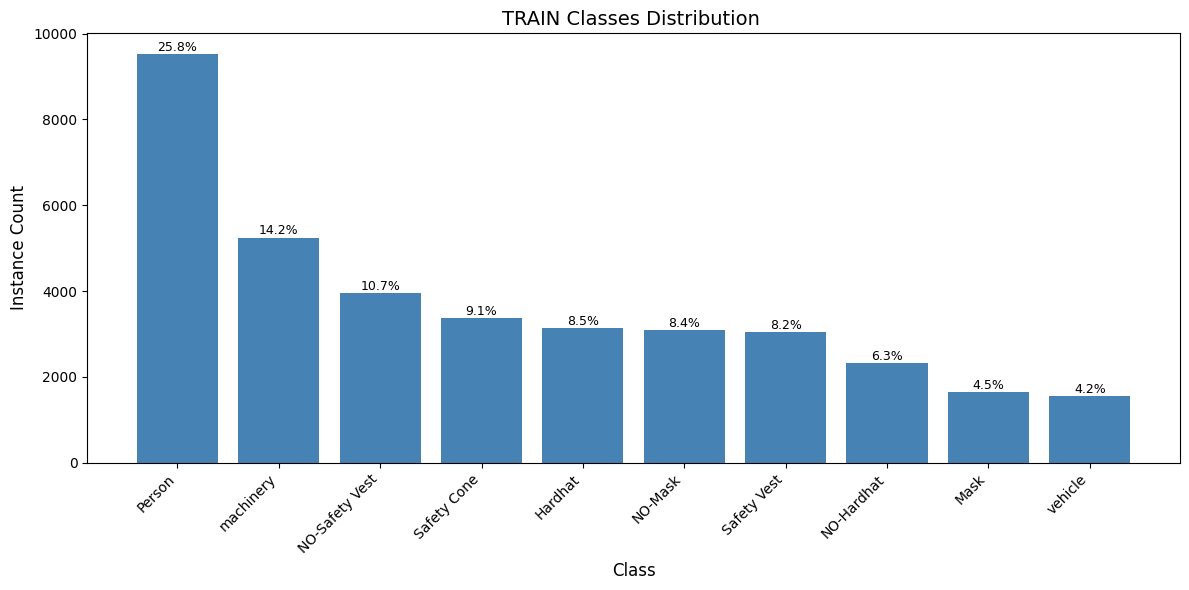

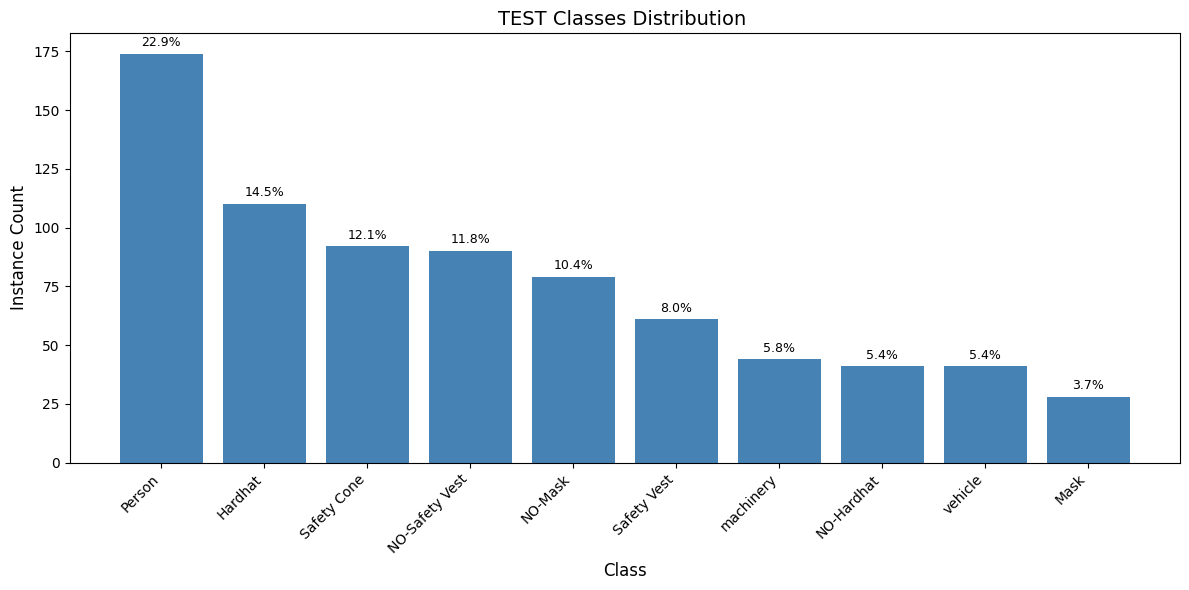

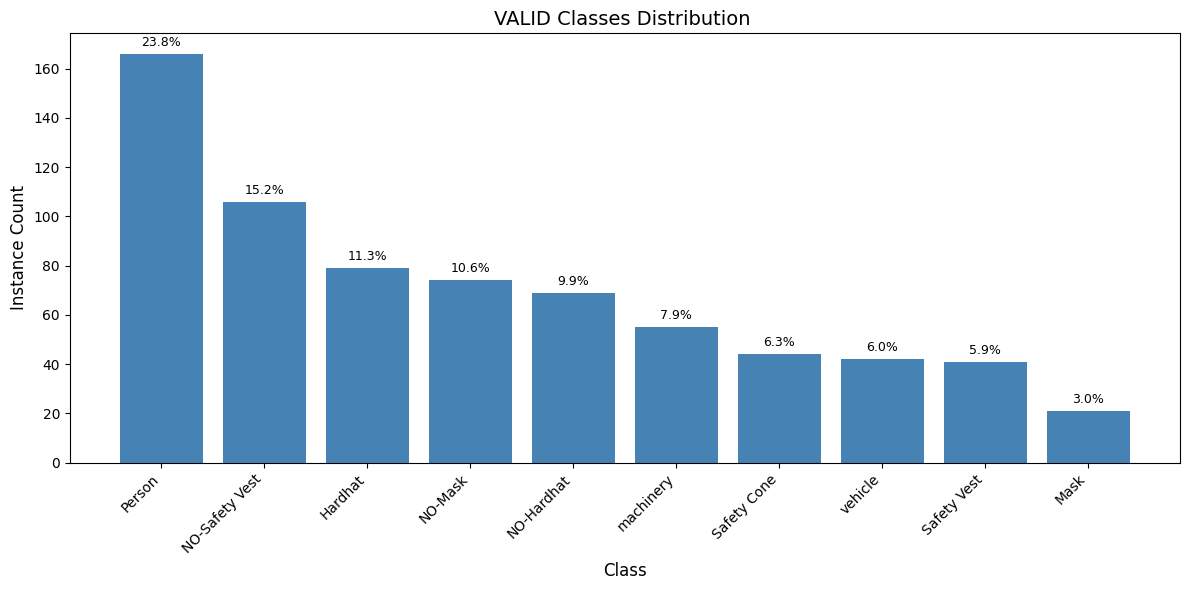

In [13]:
import os
from collections import Counter
import matplotlib.pyplot as plt

# Config
BASE_PATH = "../input/construction-site-safety-image-dataset-roboflow/css-data/"
splits = ['train', 'test', 'valid']
class_map = {
    0: 'Hardhat', 1: 'Mask', 2: 'NO-Hardhat', 3: 'NO-Mask', 4: 'NO-Safety Vest',
    5: 'Person', 6: 'Safety Cone', 7: 'Safety Vest', 8: 'machinery', 9: 'vehicle'
}
num_classes = len(class_map)

# Function to compute class counts
def get_class_distribution(label_path):
    counts = Counter()
    for fname in os.listdir(label_path):
        if fname.endswith('.txt'):
            with open(os.path.join(label_path, fname), 'r') as f:
                for line in f:
                    cls = int(line.strip().split()[0])
                    counts[cls] += 1
    return [counts.get(i, 0) for i in range(num_classes)]

# Plotting function with sorting
def plot_distribution(counts, split_name):
    total = sum(counts)
    percentages = [100 * c / total if total > 0 else 0 for c in counts]
    labels = [class_map[i] for i in range(num_classes)]

    # Combine and sort
    combined = sorted(zip(labels, counts, percentages), key=lambda x: x[1], reverse=True)
    sorted_labels, sorted_counts, sorted_percentages = zip(*combined)

    # Plot
    plt.figure(figsize=(12, 6))
    bars = plt.bar(sorted_labels, sorted_counts, color='steelblue')
    plt.title(f"{split_name.upper()} Classes Distribution ", fontsize=14)
    plt.xlabel("Class", fontsize=12)
    plt.ylabel("Instance Count", fontsize=12)

    for bar, pct in zip(bars, sorted_percentages):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 2, f"{pct:.1f}%", ha='center', va='bottom', fontsize=9)

    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Loop through splits and plot
for split in splits:
    label_dir = os.path.join(BASE_PATH, split, "labels")
    class_counts = get_class_distribution(label_dir)
    plot_distribution(class_counts, split)


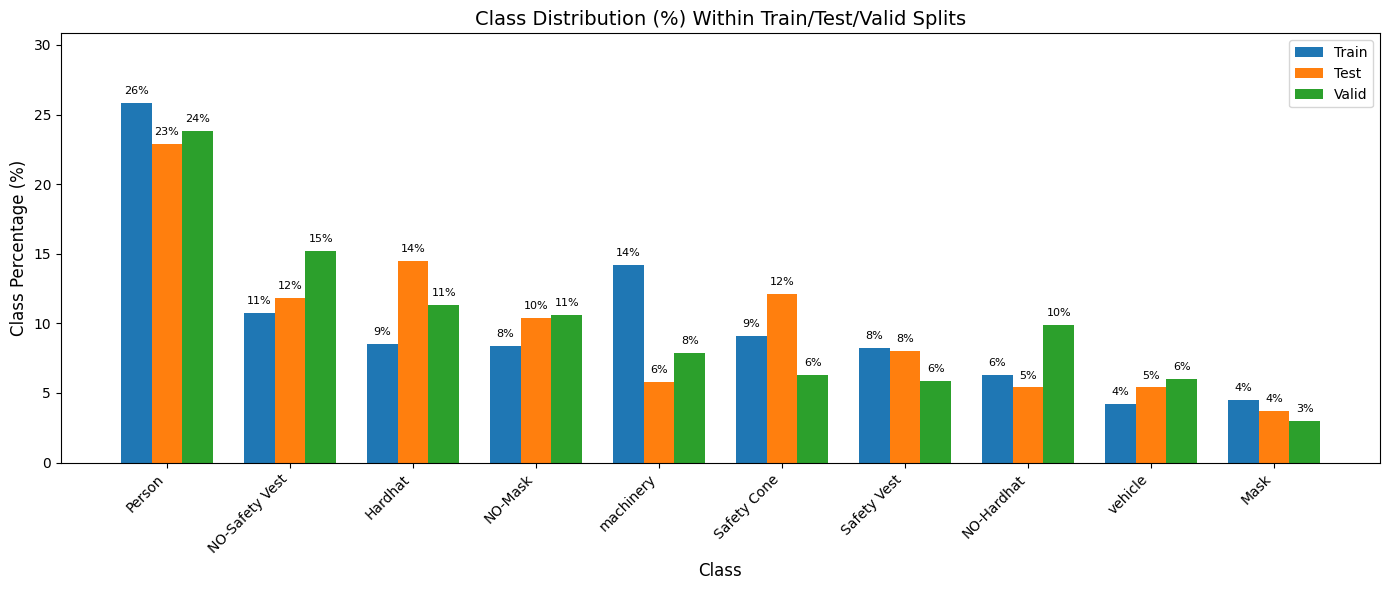

In [23]:
import os
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

# Config
BASE_PATH = "../input/construction-site-safety-image-dataset-roboflow/css-data/"
splits = ['train', 'test', 'valid']
class_map = {
    0: 'Hardhat', 1: 'Mask', 2: 'NO-Hardhat', 3: 'NO-Mask', 4: 'NO-Safety Vest',
    5: 'Person', 6: 'Safety Cone', 7: 'Safety Vest', 8: 'machinery', 9: 'vehicle'
}
num_classes = len(class_map)
class_labels = [class_map[i] for i in range(num_classes)]

# Function to compute class counts
def get_class_distribution(label_path):
    counts = Counter()
    for fname in os.listdir(label_path):
        if fname.endswith('.txt'):
            with open(os.path.join(label_path, fname), 'r') as f:
                for line in f:
                    cls = int(line.strip().split()[0])
                    counts[cls] += 1
    return [counts.get(i, 0) for i in range(num_classes)]

# Get per-split percentage distributions
split_percentages = []
for split in splits:
    label_dir = os.path.join(BASE_PATH, split, "labels")
    counts = get_class_distribution(label_dir)
    total = sum(counts)
    percentages = [100 * c / total if total > 0 else 0 for c in counts]
    split_percentages.append(percentages)

# Compute average % per class across splits for sorting
avg_percent_per_class = [np.mean([split[i] for split in split_percentages]) for i in range(num_classes)]
sorted_indices = np.argsort(avg_percent_per_class)[::-1]

# Reorder all data by sorted indices
sorted_labels = [class_labels[i] for i in sorted_indices]
sorted_percentages = [
    [split[i] for i in sorted_indices] for split in split_percentages
]

# Plotting
x = np.arange(num_classes)
width = 0.25
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # train, test, valid

plt.figure(figsize=(14, 6))
for i, (split, color) in enumerate(zip(splits, colors)):
    bar_positions = x + i * width
    heights = sorted_percentages[i]
    plt.bar(bar_positions, heights, width, label=split.capitalize(), color=color)
    for j in range(num_classes):
        if heights[j] > 0:
            plt.text(bar_positions[j], heights[j] + 0.5, f"{heights[j]:.0f}%", ha='center', va='bottom', fontsize=8)

plt.xlabel("Class", fontsize=12)
plt.ylabel("Class Percentage (%)", fontsize=12)
plt.title("Class Distribution (%) Within Train/Test/Valid Splits", fontsize=14)
plt.xticks(x + width, sorted_labels, rotation=45, ha='right')
plt.ylim(0, max(max(p) for p in sorted_percentages) + 5)
plt.legend()
plt.tight_layout()
plt.show()


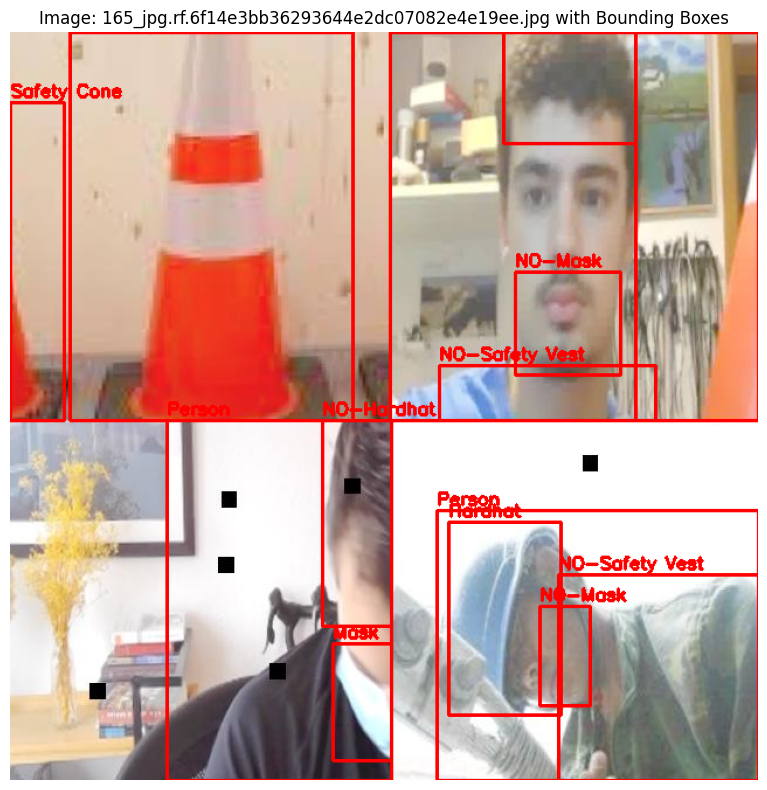

In [27]:
import os
import cv2
import matplotlib.pyplot as plt

# Config
BASE_PATH = "../input/construction-site-safety-image-dataset-roboflow/css-data/"
image_name = "165_jpg.rf.6f14e3bb36293644e2dc07082e4e19ee.jpg"
image_path = os.path.join(BASE_PATH, "train/images", image_name)
label_path = os.path.join(BASE_PATH, "train/labels", image_name.replace(".jpg", ".txt"))

# Class map
class_map = {
    0: 'Hardhat', 1: 'Mask', 2: 'NO-Hardhat', 3: 'NO-Mask', 4: 'NO-Safety Vest',
    5: 'Person', 6: 'Safety Cone', 7: 'Safety Vest', 8: 'machinery', 9: 'vehicle'
}

# Load image
img = cv2.imread(image_path)
if img is None:
    raise FileNotFoundError(f"Image not found: {image_path}")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
h, w, _ = img.shape

# Read label and draw boxes
if os.path.exists(label_path):
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            class_id = int(parts[0])
            x_center, y_center, box_w, box_h = map(float, parts[1:])
            
            # Convert YOLO to pixel coordinates
            x1 = int((x_center - box_w / 2) * w)
            y1 = int((y_center - box_h / 2) * h)
            x2 = int((x_center + box_w / 2) * w)
            y2 = int((y_center + box_h / 2) * h)

            # Draw bounding box and label
            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
            label = class_map[class_id]
            cv2.putText(img, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX,
                        0.5, (255, 0, 0), 2)
else:
    print("No label file found for image:", image_name)

# Show image
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.title(f"Image: {image_name} with Bounding Boxes")
plt.axis('off')
plt.tight_layout()
plt.show()


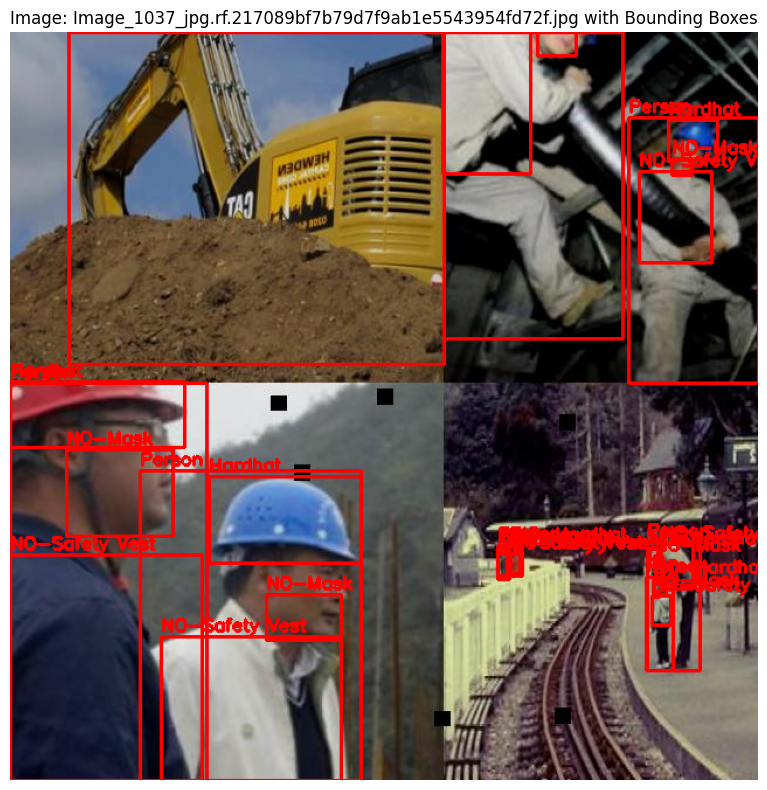

In [28]:
import os
import cv2
import matplotlib.pyplot as plt

# Config
BASE_PATH = "../input/construction-site-safety-image-dataset-roboflow/css-data/"
image_name = "Image_1037_jpg.rf.217089bf7b79d7f9ab1e5543954fd72f.jpg"
image_path = os.path.join(BASE_PATH, "train/images", image_name)
label_path = os.path.join(BASE_PATH, "train/labels", image_name.replace(".jpg", ".txt"))

# Class map
class_map = {
    0: 'Hardhat', 1: 'Mask', 2: 'NO-Hardhat', 3: 'NO-Mask', 4: 'NO-Safety Vest',
    5: 'Person', 6: 'Safety Cone', 7: 'Safety Vest', 8: 'machinery', 9: 'vehicle'
}

# Load image
img = cv2.imread(image_path)
if img is None:
    raise FileNotFoundError(f"Image not found: {image_path}")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
h, w, _ = img.shape

# Read label and draw boxes
if os.path.exists(label_path):
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            class_id = int(parts[0])
            x_center, y_center, box_w, box_h = map(float, parts[1:])
            
            # Convert YOLO to pixel coordinates
            x1 = int((x_center - box_w / 2) * w)
            y1 = int((y_center - box_h / 2) * h)
            x2 = int((x_center + box_w / 2) * w)
            y2 = int((y_center + box_h / 2) * h)

            # Draw bounding box and label
            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
            label = class_map[class_id]
            cv2.putText(img, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX,
                        0.5, (255, 0, 0), 2)
else:
    print("No label file found for image:", image_name)

# Show image
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.title(f"Image: {image_name} with Bounding Boxes")
plt.axis('off')
plt.tight_layout()
plt.show()


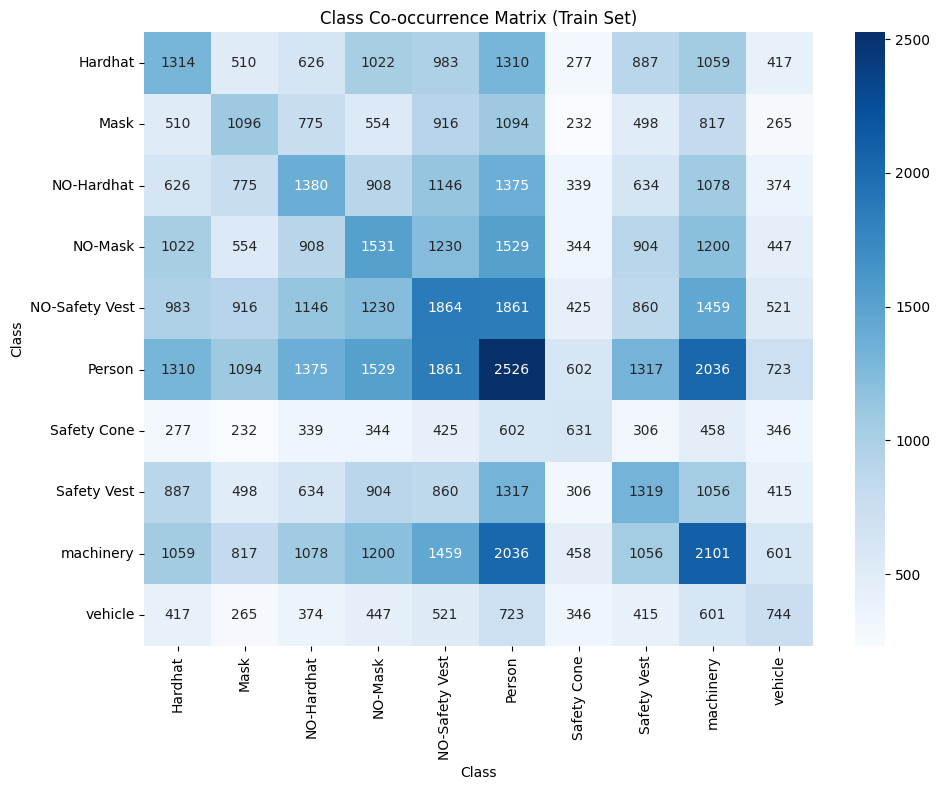

In [29]:
BASE_PATH = "../input/construction-site-safety-image-dataset-roboflow/css-data/train/"
class_map = {0:'Hardhat',1:'Mask',2:'NO-Hardhat',3:'NO-Mask',4:'NO-Safety Vest',
             5:'Person',6:'Safety Cone',7:'Safety Vest',8:'machinery',9:'vehicle'}
num_classes = len(class_map)

def get_image_classes(label_file):
    classes = set()
    with open(label_file, 'r') as f:
        for line in f:
            cls = int(line.split()[0])
            classes.add(cls)
    return classes

label_dir = os.path.join(BASE_PATH, "labels")
image_labels = [f for f in os.listdir(label_dir) if f.endswith('.txt')]

# Build co-occurrence matrix
co_matrix = np.zeros((num_classes, num_classes), dtype=int)

for label_file in image_labels:
    classes = get_image_classes(os.path.join(label_dir, label_file))
    for c1 in classes:
        for c2 in classes:
            co_matrix[c1, c2] += 1

plt.figure(figsize=(10,8))
sns.heatmap(co_matrix, annot=True, fmt='d', xticklabels=class_map.values(),
            yticklabels=class_map.values(), cmap='Blues')
plt.title("Class Co-occurrence Matrix (Train Set)")
plt.xlabel("Class")
plt.ylabel("Class")
plt.tight_layout()
plt.show()


In [34]:
set(widths), set(heights)

({640}, {640})

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


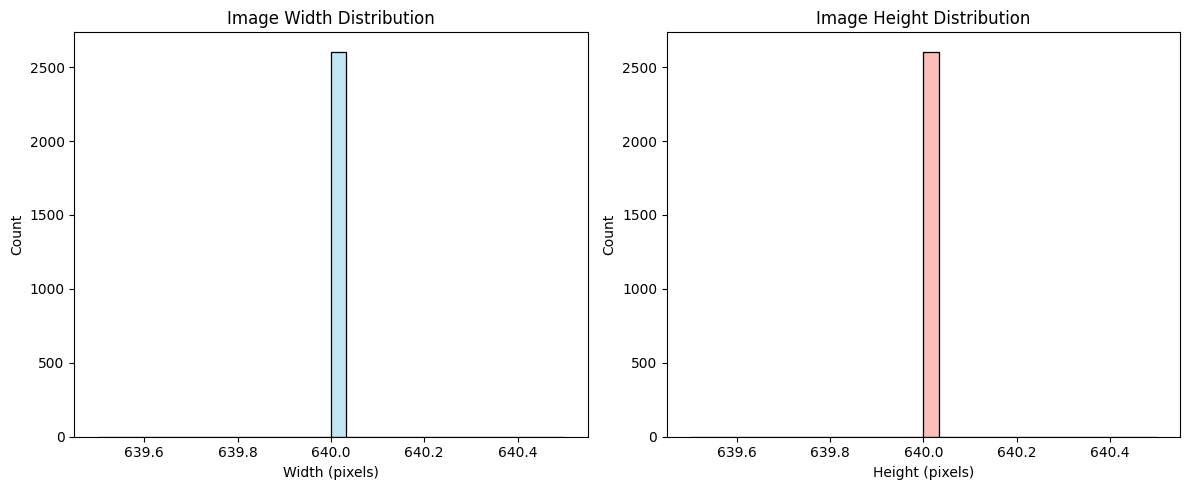

In [30]:
image_dir = os.path.join(BASE_PATH, "images")
widths, heights = [], []

for img_file in os.listdir(image_dir):
    if img_file.endswith(('.jpg', '.png')):
        img_path = os.path.join(image_dir, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            h, w = img.shape[:2]
            widths.append(w)
            heights.append(h)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(widths, bins=30, kde=True, color='skyblue')
plt.title("Image Width Distribution")
plt.xlabel("Width (pixels)")

plt.subplot(1,2,2)
sns.histplot(heights, bins=30, kde=True, color='salmon')
plt.title("Image Height Distribution")
plt.xlabel("Height (pixels)")
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


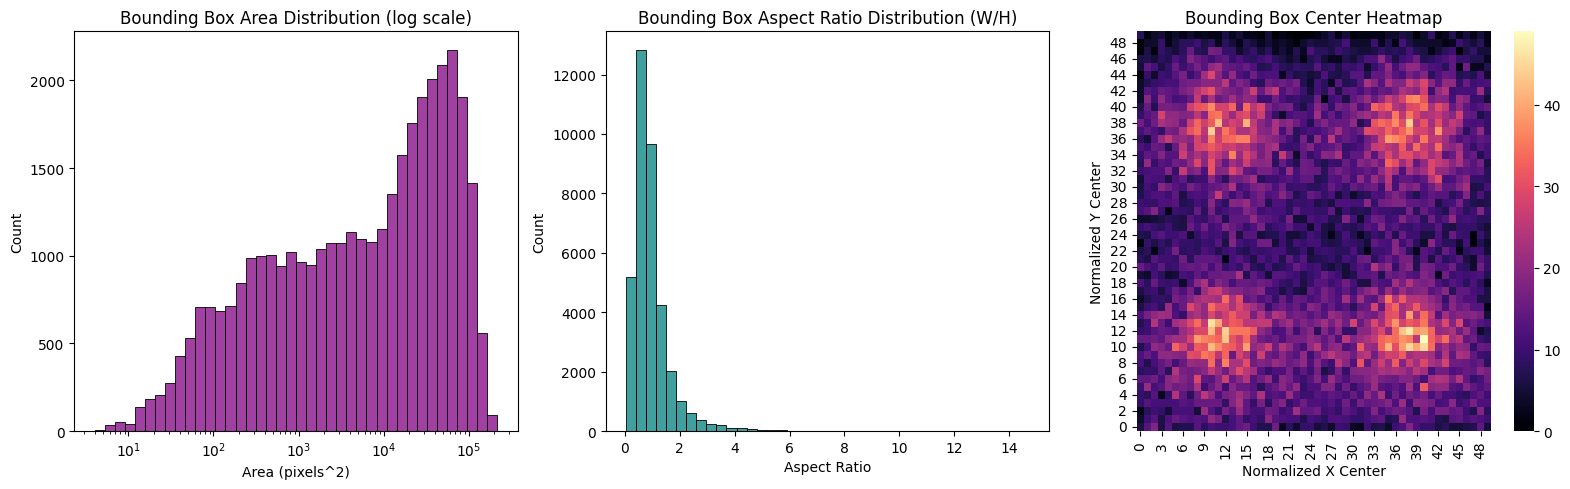

In [35]:
label_dir = os.path.join(BASE_PATH, "labels")
image_dir = os.path.join(BASE_PATH, "images")

areas = []
aspect_ratios = []
centers_x = []
centers_y = []

for label_file in os.listdir(label_dir):
    if label_file.endswith('.txt'):
        label_path = os.path.join(label_dir, label_file)
        image_file = label_file.replace('.txt', '.jpg')
        image_path = os.path.join(image_dir, image_file)

        img = cv2.imread(image_path)
        if img is None:
            continue
        h, w = img.shape[:2]

        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                cls = int(parts[0])
                x_center, y_center, box_w, box_h = map(float, parts[1:])

                # Convert normalized bbox to pixels
                box_w_px = box_w * w
                box_h_px = box_h * h
                area = box_w_px * box_h_px
                aspect_ratio = box_w_px / box_h_px if box_h_px != 0 else 0

                areas.append(area)
                aspect_ratios.append(aspect_ratio)
                centers_x.append(x_center)
                centers_y.append(y_center)

# Plot bbox area distribution
plt.figure(figsize=(16,5))
plt.subplot(1,3,1)
sns.histplot(areas, bins=40, log_scale=True, color='purple')
plt.title("Bounding Box Area Distribution (log scale)")
plt.xlabel("Area (pixels^2)")

# Plot aspect ratio distribution
plt.subplot(1,3,2)
sns.histplot(aspect_ratios, bins=40, color='teal')
plt.title("Bounding Box Aspect Ratio Distribution (W/H)")
plt.xlabel("Aspect Ratio")

# Plot bbox center heatmap
plt.subplot(1,3,3)
heatmap_data, xedges, yedges = np.histogram2d(centers_x, centers_y, bins=50, range=[[0,1],[0,1]])
sns.heatmap(heatmap_data.T, cmap='magma', cbar=True)
plt.title("Bounding Box Center Heatmap")
plt.xlabel("Normalized X Center")
plt.ylabel("Normalized Y Center")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


# Data Augmentation 

In [40]:
import os
import pandas as pd

BASE_PATH = "../input/construction-site-safety-image-dataset-roboflow/css-data/"
LABEL_FOLDERS = ['train', 'valid', 'test']
PPE_CLASSES = {
    0: 'Hardhat', 1: 'Mask', 2: 'NO-Hardhat', 3: 'NO-Mask', 4: 'NO-Safety Vest',
    5: 'Person', 6: 'Safety Cone', 7: 'Safety Vest', 8: 'Machinery', 9: 'Vehicle'
}

records = []

for split in LABEL_FOLDERS:
    label_dir = os.path.join(BASE_PATH, split, 'labels')
    # List all label files
    label_files = [f for f in os.listdir(label_dir) if f.endswith('.txt')]
    
    for label_file in label_files:
        # Initialize class presence dict (0/1)
        class_presence = {cls_name: 0 for cls_name in PPE_CLASSES.values()}
        
        file_path = os.path.join(label_dir, label_file)
        with open(file_path, 'r') as f:
            lines = f.readlines()
            classes_in_image = set()
            for line in lines:
                cls_id = int(line.strip().split()[0])
                classes_in_image.add(cls_id)
        
        # Mark presence 1 for classes found in this image
        for cls_id in classes_in_image:
            class_presence[PPE_CLASSES[cls_id]] = 1
        
        # Record image info
        image_id = os.path.splitext(label_file)[0]  # file name without extension
        records.append({
            'image_id': image_id,
            'origin': split,
            **class_presence
        })

# Create DataFrame
df_image_classes = pd.DataFrame(records)

# Optional: Preview
df_image_classes.head()

,image_id,origin,Hardhat,Mask,NO-Hardhat,NO-Mask,NO-Safety Vest,Person,Safety Cone,Safety Vest,Machinery,Vehicle
0,youtube-270_jpg.rf.9ae5283f885f67c55f351ac2d03...,train,0,1,0,0,1,1,0,1,1,1
1,Image_1009_jpg.rf.42a85f154507fc3c69facf93bbb1...,train,0,0,1,1,1,1,1,0,1,1
2,youtube-693_jpg.rf.c5a5784a786a21f09fa8df370f7...,train,1,0,0,1,0,1,1,1,1,1
3,IMG_0871_mp4-10_jpg.rf.316b943fdf8f56161e0005b...,train,0,1,0,0,1,1,0,0,1,0
4,ka_00884_png_jpg.rf.7e1eb708ba18a96826b2667c8d...,train,0,0,1,1,0,1,1,1,1,0


In [42]:
import os
import pandas as pd

BASE_PATH = "../input/construction-site-safety-image-dataset-roboflow/css-data/"
LABEL_FOLDERS = ['train', 'valid', 'test']
PPE_CLASSES = {
    0: 'Hardhat', 1: 'Mask', 2: 'NO-Hardhat', 3: 'NO-Mask', 4: 'NO-Safety Vest',
    5: 'Person', 6: 'Safety Cone', 7: 'Safety Vest', 8: 'Machinery', 9: 'Vehicle'
}

records = []

for split in LABEL_FOLDERS:
    label_dir = os.path.join(BASE_PATH, split, 'labels')
    label_files = [f for f in os.listdir(label_dir) if f.endswith('.txt')]
    
    for label_file in label_files:
        # Initialize counts with zero
        class_counts = {cls_name: 0 for cls_name in PPE_CLASSES.values()}
        
        file_path = os.path.join(label_dir, label_file)
        with open(file_path, 'r') as f:
            lines = f.readlines()
            for line in lines:
                cls_id = int(line.strip().split()[0])
                class_counts[PPE_CLASSES[cls_id]] += 1
        
        image_id = os.path.splitext(label_file)[0]
        records.append({
            'image_id': image_id,
            'origin': split,
            **class_counts
        })

df_image_class_counts = pd.DataFrame(records)

# Optional: Preview
df_image_class_counts.head()

,image_id,origin,Hardhat,Mask,NO-Hardhat,NO-Mask,NO-Safety Vest,Person,Safety Cone,Safety Vest,Machinery,Vehicle
0,youtube-270_jpg.rf.9ae5283f885f67c55f351ac2d03...,train,0,1,0,0,1,2,0,1,2,2
1,Image_1009_jpg.rf.42a85f154507fc3c69facf93bbb1...,train,0,0,1,1,1,1,12,0,1,3
2,youtube-693_jpg.rf.c5a5784a786a21f09fa8df370f7...,train,1,0,0,1,0,3,2,2,2,1
3,IMG_0871_mp4-10_jpg.rf.316b943fdf8f56161e0005b...,train,0,2,0,0,2,2,0,0,2,0
4,ka_00884_png_jpg.rf.7e1eb708ba18a96826b2667c8d...,train,0,0,1,1,0,1,3,1,4,0


In [46]:
df_image_class_counts.to_csv("data.csv")

In [47]:
agg

,origin,image_id,Hardhat,Mask,NO-Hardhat,NO-Mask,NO-Safety Vest,Person,Safety Cone,Safety Vest,Machinery,Vehicle
0,test,youtube-631_jpg.rf.7c6ecf859c1b0a659f8ea057ad2...,110,28,41,79,90,174,92,61,44,41
1,train,youtube-270_jpg.rf.9ae5283f885f67c55f351ac2d03...,3145,1651,2317,3097,3962,9532,3366,3033,5247,1545
2,valid,construction-3-_mp4-219_jpg.rf.416dbf917b54d58...,79,21,69,74,106,166,44,41,55,42


/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


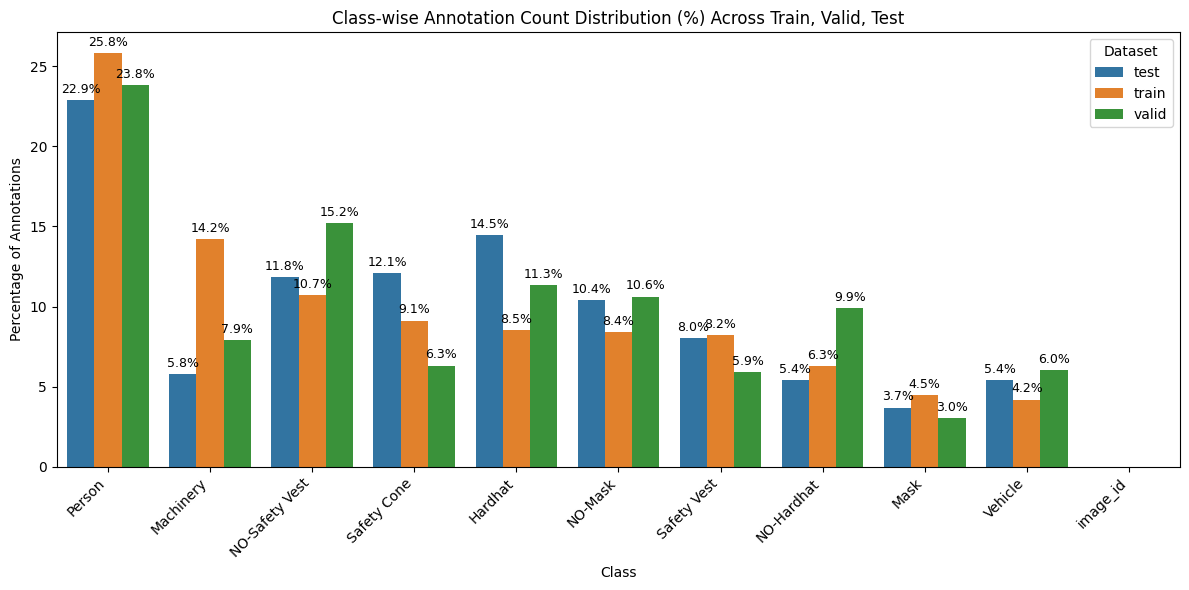

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assume df_image_class_counts is loaded from previous step

# Sum annotation counts per class for each split
agg = df_image_class_counts.groupby('origin').sum().reset_index()

# Melt for easier plotting (long format)
df_melt = agg.melt(id_vars='origin', var_name='Class', value_name='Count')

# Ensure 'Count' is numeric
df_melt['Count'] = pd.to_numeric(df_melt['Count'], errors='coerce').fillna(0)

# Calculate total annotations per split
total_per_split = df_melt.groupby('origin')['Count'].transform('sum')

# Calculate % per class per split
df_melt['Percentage'] = df_melt['Count'] / total_per_split * 100

# Sort classes by train percentage
train_order = df_melt[df_melt['origin'] == 'train'].sort_values('Percentage', ascending=False)['Class']
df_melt['Class'] = pd.Categorical(df_melt['Class'], categories=train_order, ordered=True)

# Plotting
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # train, valid, test colors
ax = sns.barplot(data=df_melt, x='Class', y='Percentage', hue='origin', palette=colors)

# Add labels on bars
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{height:.1f}%', 
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=9, color='black', xytext=(0, 3),
                    textcoords='offset points')

# Formatting
plt.title('Class-wise Annotation Count Distribution (%) Across Train, Valid, Test')
plt.xlabel('Class')
plt.ylabel('Percentage of Annotations')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()
